# LangChain for Vector Store Creation

In this notebook, we will create a ChromaDB vector store based on the pdf file with the information about the portfolio of Burock. It will serve as a guide to create other types of vector stores based on pdf documents.

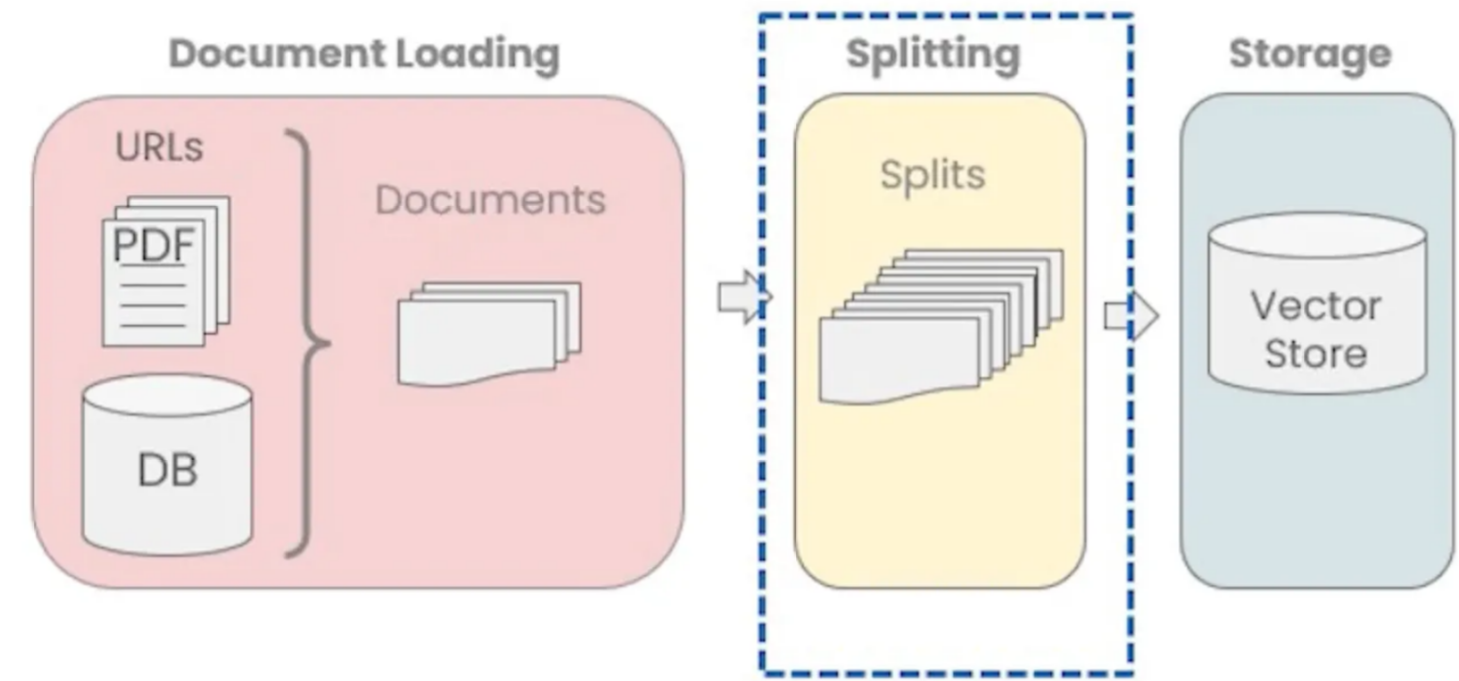

## Loading PDF

LangChain provides document loaders. These loaders allow you to load data from a source as a Document. A Document is a piece of text and associated metadata. For example, there are document loaders for loading .txt files, for loading the text contents of any web page, or even for loading a transcript of a YouTube video.

Document loaders provide a "load" method for loading data as documents from a configured source, and this is what we will be using. We will load our pdf file with all information about the portfolio of Burock. These documents were generated by scraping Burock's portfolio in the website. Langchain has many kinds of document loaders. You can check them out [here](https://python.langchain.com/docs/modules/data_connection/document_loaders/).

In [1]:
from dotenv import load_dotenv
load_dotenv()
from langchain_community.document_loaders import PyPDFLoader
loader = PyPDFLoader("../utils/burock_software_consultancy_portfolio.pdf")
pages = loader.load()

In [2]:
print(f'The burock_software_consultancy_portfolio.pdf file has {len(pages)} pages.')

The burock_software_consultancy_portfolio.pdf file has 100 pages.


In [3]:
pages[0]?

Type:           Document
String form:   
page_content='Project Name: ERM Suite Platinum
           Technologies: Python, Django, React, PostgreSQL
           Ca <...> ils/burock_software_consultancy_portfolio.pdf', 'total_pages': 100, 'page': 0, 'page_label': '1'}
File:           c:\users\burak.cevik\miniconda3\envs\ai-assistant\lib\site-packages\langchain_core\documents\base.py
Docstring:     
Class for storing a piece of text and associated metadata.

!!! note

    `Document` is for **retrieval workflows**, not chat I/O. For sending text
    to an LLM in a conversation, use message types from `langchain.messages`.

Example:
    ```python
    from langchain_core.documents import Document

    document = Document(
        page_content="Hello, world!", metadata={"source": "https://example.com"}
    )
    ```
Init docstring: Pass page_content in as positional or named arg.

In [4]:
print(pages[5].page_content)

Project Name: SmartHome Mesh
Technologies: Node.js, MQTT, MongoDB, AWS IoT
Category: IoT Systems
Industry: Consumer Electronics
Services: IoT Integration, Firmware
Description:
A unified control center for smart devices supporting Zigbee and Matter. Features edge processing for
low-latency control.
Link: www.[website].com/smarthome-mesh/


In [5]:
pages[5].metadata

{'producer': 'PyFPDF 1.7.2 http://pyfpdf.googlecode.com/',
 'creator': 'PyPDF',
 'creationdate': 'D:20260209202427',
 'source': '../utils/burock_software_consultancy_portfolio.pdf',
 'total_pages': 100,
 'page': 5,
 'page_label': '6'}

In [6]:
for i in range(0, len(pages)):
    pages[i].page_content = pages[i].page_content.replace(' -', '-')

In [7]:
print(pages[5].page_content)

Project Name: SmartHome Mesh
Technologies: Node.js, MQTT, MongoDB, AWS IoT
Category: IoT Systems
Industry: Consumer Electronics
Services: IoT Integration, Firmware
Description:
A unified control center for smart devices supporting Zigbee and Matter. Features edge processing for
low-latency control.
Link: www.[website].com/smarthome-mesh/


## Document Splitting

Once you've loaded the documents, you'll often want to transform them to better suit your application. For example, you may want to split a long document into smaller chunks that can fit into your model's context window. LangChain has a number of built-in document transformers that make it easy to split, combine, filter, and otherwise manipulate documents.

Now that we know how to load documents with langchain, we now need to split the document in smaller chunks. In our case what's important is that each project is chunked together for us not to lose valuable context for each project. To do this, we will use the text_splitters that LangChain provides, you can look at them [here](https://python.langchain.com/docs/modules/data_connection/document_transformers/).

In [8]:
from langchain_text_splitters import CharacterTextSplitter

In [9]:
text_splitter = CharacterTextSplitter(
        separator="\n",
        chunk_size=5000,
        chunk_overlap=300,
        length_function=len
    )

In [10]:
docs = text_splitter.split_documents(pages)

In [11]:
print(f'We have a total of {len(docs)} chunks. This will be the same as the number of documents due to the structure of our document')

We have a total of 100 chunks. This will be the same as the number of documents due to the structure of our document


## Vector Store Creation
Now that we have our data split into several meaningful chunks, it's time to put these chunks into an index so that we can later retrieve them to answer questions about this data. To do this, we are going to use Embeddings and a Vector Store.

An embedding model takes a piece of text and creates a numerical representation of that text. Texts with similar content will have similar vectors in this numeric space. What this means is that we can then retrieve pieces of texts that are similar to one another from the vector store. We just need to use an embedding model to create a vector embedding for our query, and then, use a similarity search algorithm to pick the ``n`` most similar documents from our vector store.


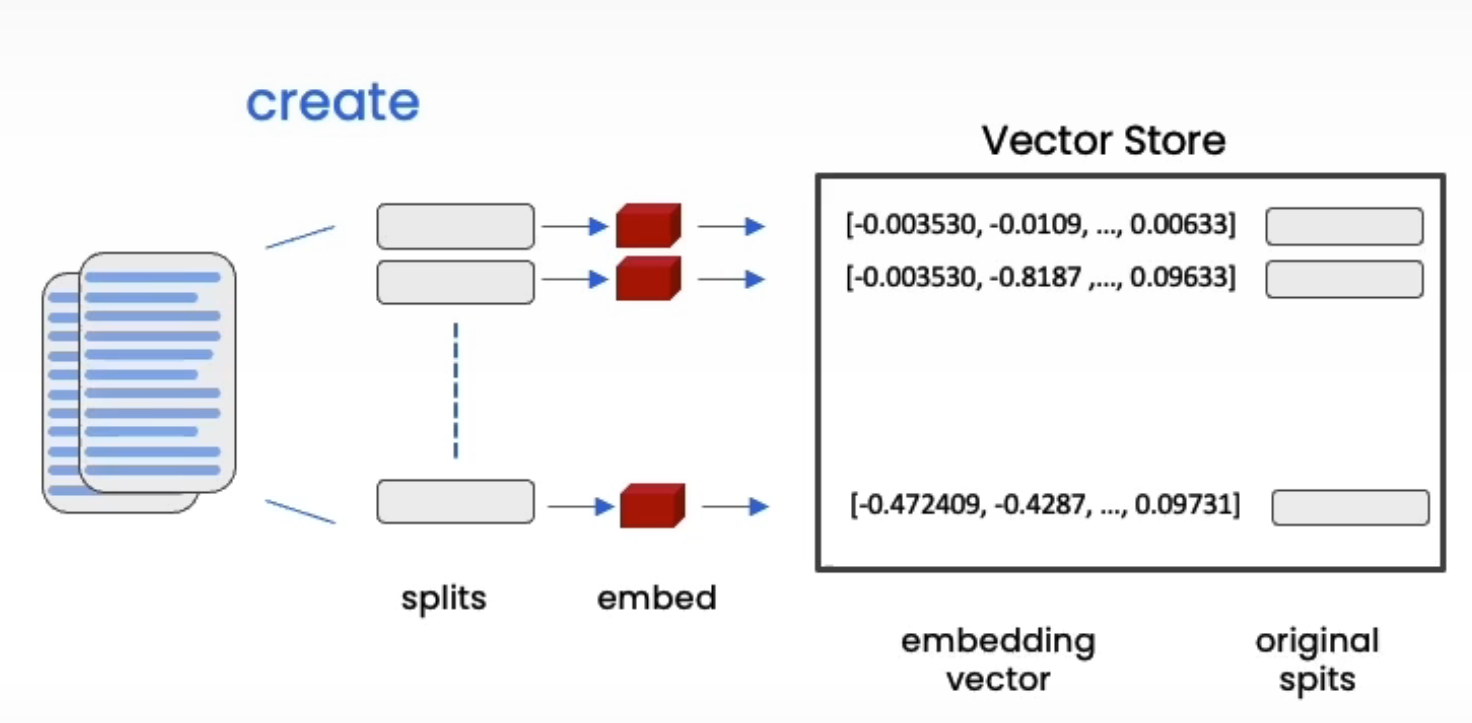

We will be using ChromaDB for this vector store. It's a libary that allows developers to quickly search for embeddings of multimedia documents that are similar to each other. There are many other vector stores in langchain that could be used and you can check them out [here](https://python.langchain.com/docs/modules/data_connection/vectorstores/). As for our embedding model, we are going to be using text-embedding-ada-002 from openAI. You can check more information about the different embedding models that OpenAI offers clicking [here](https://platform.openai.com/docs/guides/embeddings/what-are-embeddings).

In [12]:
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings()


In [13]:
import shutil
import os

persist_directory = '../utils/vector-store'

if os.path.exists(persist_directory):
    # Remove the directory and all its contents
    shutil.rmtree(persist_directory)

In [15]:
vectordb = Chroma.from_documents(
    documents=docs,
    embedding=embeddings,
    persist_directory=persist_directory
)

## Retrieve Documents

At last, we can create a retriever. A retriever is an interface that returns documents given an unstructured query. There are many kinds of retrievers and you can check them out in [here](https://python.langchain.com/docs/modules/data_connection/retrievers/). For this particular case, we will define that our metric for searching documents will be based on a similarity search and only retrive the top 3 documents most similar to our question.

In [16]:
retriever = vectordb.as_retriever(
                search_type="similarity",
                search_kwargs={
                    "k": 3,
                },
            )

In [18]:
documents = retriever.invoke('projects related to react')
for doc in documents:
    print(doc.page_content)
    print('\n')

Project Name: Cloud PatientFlow EMR
Technologies: Java, Spring Boot, React Native, MySQL
Category: Healthcare Portals
Industry: Medical
Services: HIPAA Compliance, Mobile Dev
Description:
Streamlining clinical workflows through digitized records. Integrates EHR/EMR systems with high-definition
telemedicine suites and AI triage.
Link: www.[website].com/cloud-patientflow-emr/


Project Name: Cloud PatientFlow EMR
Technologies: Java, Spring Boot, React Native, MySQL
Category: Healthcare Portals
Industry: Medical
Services: HIPAA Compliance, Mobile Dev
Description:
Streamlining clinical workflows through digitized records. Integrates EHR/EMR systems with high-definition
telemedicine suites and AI triage.
Link: www.[website].com/cloud-patientflow-emr/


Project Name: Pro PatientFlow EMR
Technologies: Java, Spring Boot, React Native, MySQL
Category: Healthcare Portals
Industry: Medical
Services: HIPAA Compliance, Mobile Dev
Description:
Streamlining clinical workflows through digitized record